In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
# Cargar csv y ver información.
preis_haus_EU = pd.read_csv("estat_tipsho20_en.csv", delimiter=",", encoding="utf-8")
cpc_DE = preis_haus_EU[preis_haus_EU["geo"] == "DE"]
cpc_DE_00_23 = cpc_DE[(cpc_DE["TIME_PERIOD"] >= 2000) & (cpc_DE["TIME_PERIOD"] <= 2023)]
print(cpc_DE_00_23.info())
print(cpc_DE_00_23.describe())

In [ ]:
# Selección de los datos en Alemania y verificación de datos nulos o faltantes.
is_na = cpc_DE_00_23[cpc_DE_00_23["geo"] == "DE"].isnull()
cpc_DE_00_23[cpc_DE_00_23[is_na]].sum()

In [ ]:
# Cambiar de float a int la columna TIME_PERIOD
cpc_DE_00_23["TIME_PERIOD"] = pd.to_numeric(cpc_DE_00_23["TIME_PERIOD"])
cpc_DE_00_23["OBS_VALUE"] = pd.to_numeric(cpc_DE_00_23["OBS_VALUE"])
print(cpc_DE_00_23["TIME_PERIOD"].sort_values())

# Borrar duplicados y buscar valores nulos.
cpc_DE_00_23["TIME_PERIOD"] = cpc_DE_00_23["TIME_PERIOD"].drop_duplicates()
print(f"Encontrado {cpc_DE_00_23.loc[:,"TIME_PERIOD"].duplicated().sum()} valores duplicados")
print(f"Encontrados {cpc_DE_00_23.loc[:,"TIME_PERIOD"].isnull().sum()} valores NaN")

In [ ]:
# Buscado valores atípicos de los precios (IQR).
Q1 = cpc_DE_00_23["OBS_VALUE"].quantile(0.25)
Q3 = cpc_DE_00_23["OBS_VALUE"].quantile(0.50)
IQR = Q3 - Q1

# Definir los limites
upper_limit = Q3 + 1.5 * IQR 
lower_limit = Q1 - 1.5 * IQR

# Aplicar limites a los valores.
outliers = cpc_DE_00_23[(cpc_DE_00_23["OBS_VALUE"] < lower_limit) | (cpc_DE_00_23["OBS_VALUE"] > upper_limit)]
outliers.describe()

In [ ]:
# Ver mínimos y máximos.
y_min = cpc_DE_00_23["OBS_VALUE"].min()
print(y_min)
y_max = cpc_DE_00_23["OBS_VALUE"].max()
print(y_max)
ticks = np.arange(y_min, y_max + 10, 25)

In [32]:
# Tomar fecha y valor y eliminar los NaN
model_sold = cpc_DE_00_23[["TIME_PERIOD", "OBS_VALUE"]]
model_sold = model_sold[["TIME_PERIOD", "OBS_VALUE"]].dropna().reset_index(drop=True)

# Definir x (año) y y (precio)
x = sm.add_constant(model_sold["TIME_PERIOD"])
y = model_sold["OBS_VALUE"]

# Ajustar el modelo
model = sm.OLS(y, x).fit()
print(model.summary())

# De Series se pasa a un dataframe para la creación de la linea de predicción.
predictions = pd.DataFrame({"TIME_PERIOD": x["TIME_PERIOD"],
                            "PREDICT": model.predict(x)})

                            OLS Regression Results                            
Dep. Variable:              OBS_VALUE   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     69.73
Date:                Fri, 20 Jun 2025   Prob (F-statistic):           2.88e-08
Time:                        10:03:27   Log-Likelihood:                -94.700
No. Observations:                  24   AIC:                             193.4
Df Residuals:                      22   BIC:                             195.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6371.8997    775.324     -8.218      

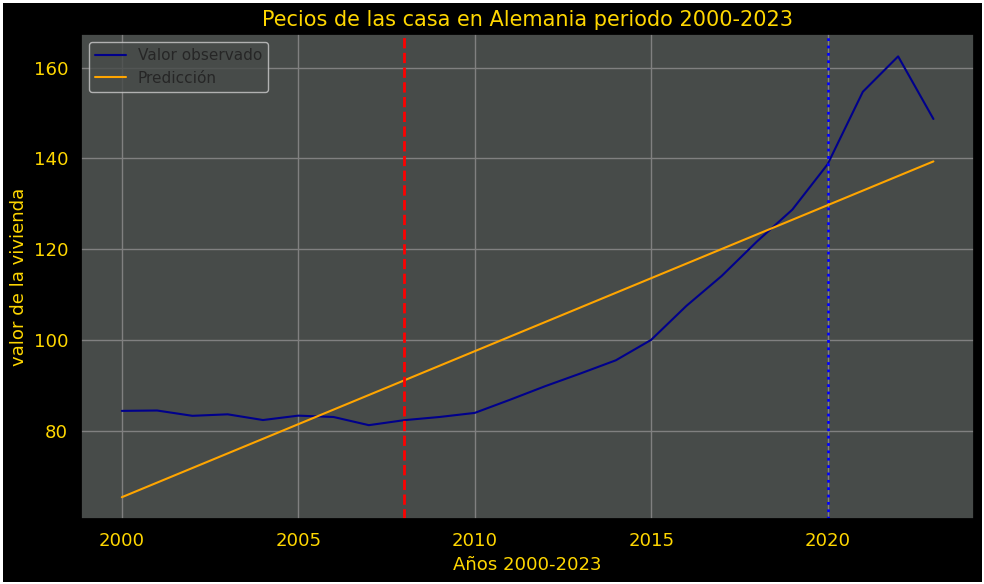

In [50]:
# Fondo general sns.
sns.set_theme(style="darkgrid", rc={
        "axes.facecolor": "#474b49",
        "figure.facecolor": "#050505",
        "axes.edgecolor": "black",
        "grid.color": "gray"
    })

# Se crea de forma explícita la figura y el eje.
fig, ax = plt.subplots(figsize=(10, 6), linewidth=2.5)
fig.patch.set_facecolor("black")

# Lineas de datos en el gráfico.
sns.lineplot(data=model_sold, x="TIME_PERIOD", y="OBS_VALUE", label="Valor observado", color="darkblue", ax=ax)
sns.lineplot(x="TIME_PERIOD", y="PREDICT", data=predictions, label="Predicción", color="orange", ax=ax)

# Personalizar los ejes.
ax.tick_params(axis="x", colors="gold", labelsize=13)
ax.tick_params(axis="y", colors="gold", labelsize=13)

# Crear Título principal y títulos de ejes.
ax.set_title("Pecios de las casa en Alemania periodo 2000-2023", color="gold", fontsize=15)
ax.set_ylabel("valor de la vivienda", color="gold", fontsize=13)
ax.set_xlabel("Años 2000-2023", color="gold", fontsize=13)

# Crea lines verticales de eventos claves.
ax.axvline(2008, color="red", linestyle="--", linewidth=2.0)
ax.axvline(2020, color="blue", linestyle=":", linewidth=2.0)

# leyenda automatica.
plt.legend()

plt.tight_layout()